## import

In [3]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchinfo
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.semantic_segmentation.models.deeplab import DeepLab

# setting

In [4]:
artifacts_path = Path("../../artifacts/deeplab")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [5]:
DEVICE = torch.device("cuda:0")

# data

In [6]:
BATCH_SIZE = 32
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [7]:
class DownScaleTransform(torch.nn.Module):
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.interpolate(
            x.expand(1, 1, *x.shape),
            size=TRAIN_IMAGE_SIZE // self.scale_factor + 1,
            mode='nearest',
        ).squeeze()

In [8]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

train_label_transform = T.Compose(
    [
        DownScaleTransform(8),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [9]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
    label_transform=train_label_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [10]:
NUM_WORKERS = get_num_workers()

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

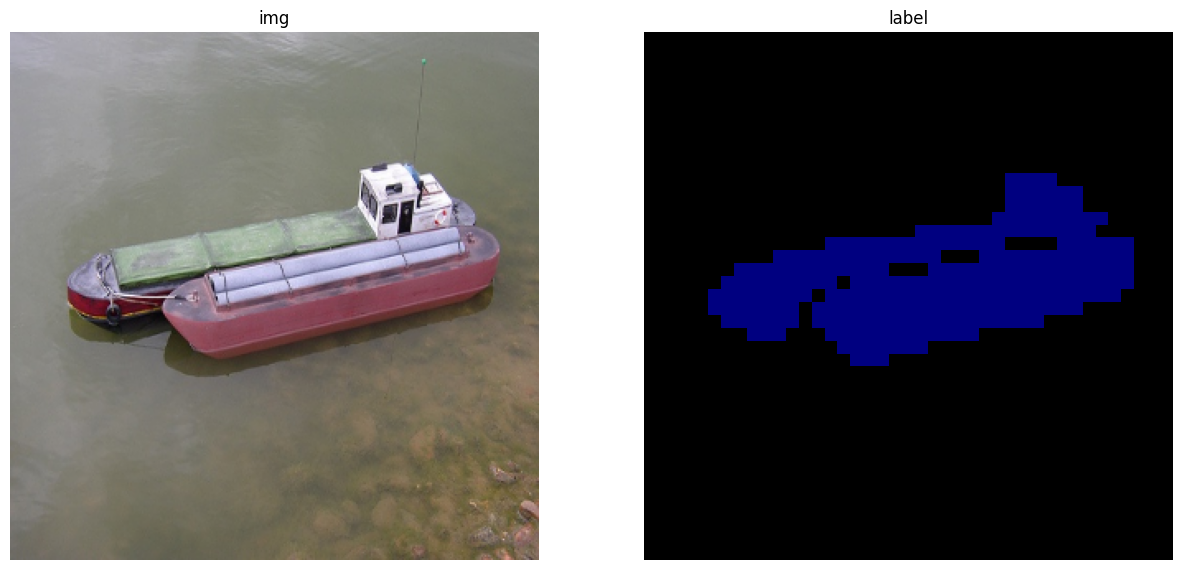

In [12]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [15]:
model = DeepLab(NUM_CLASS + 1, frozen_backbone=True).to(DEVICE)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
DeepLab                                       --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      (590,080)
│    │    └─ReLU: 3

# train

In [13]:
EPOCHS = 30

In [14]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [16]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 91/91 [02:46<00:00,  1.83s/it]


epoch 1 : 0.034852234789958365


100%|██████████| 91/91 [00:41<00:00,  2.17it/s]


epoch 2 : 0.018834111761752065


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 3 : 0.014893266658943433


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 4 : 0.01298556741900169


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 5 : 0.011944937284339915


100%|██████████| 91/91 [00:42<00:00,  2.17it/s]


epoch 6 : 0.01110468421049498


100%|██████████| 91/91 [00:42<00:00,  2.15it/s]


epoch 7 : 0.010307133279658936


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 8 : 0.009779956099669357


100%|██████████| 91/91 [00:41<00:00,  2.17it/s]


epoch 9 : 0.009250623875062217


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 10 : 0.008697761053853965


100%|██████████| 91/91 [00:42<00:00,  2.17it/s]


epoch 11 : 0.008186604663893416


100%|██████████| 91/91 [00:42<00:00,  2.16it/s]


epoch 12 : 0.007876292423723818


100%|██████████| 91/91 [00:42<00:00,  2.17it/s]


epoch 13 : 0.007490553739634189


100%|██████████| 91/91 [00:41<00:00,  2.17it/s]


epoch 14 : 0.007178528515806237


100%|██████████| 91/91 [00:42<00:00,  2.17it/s]


epoch 15 : 0.006823539068656308


100%|██████████| 91/91 [00:45<00:00,  1.98it/s]


epoch 16 : 0.006535036868037103


100%|██████████| 91/91 [00:45<00:00,  1.99it/s]


epoch 17 : 0.006227945289728078


100%|██████████| 91/91 [00:44<00:00,  2.05it/s]


epoch 18 : 0.005943796704881466


100%|██████████| 91/91 [00:44<00:00,  2.06it/s]


epoch 19 : 0.005702438759156964


100%|██████████| 91/91 [00:43<00:00,  2.07it/s]


epoch 20 : 0.005485438401452624


100%|██████████| 91/91 [00:44<00:00,  2.06it/s]


epoch 21 : 0.0052755247637793256


100%|██████████| 91/91 [00:44<00:00,  2.05it/s]


epoch 22 : 0.005071504238563089


100%|██████████| 91/91 [00:43<00:00,  2.08it/s]


epoch 23 : 0.004871684016537044


100%|██████████| 91/91 [00:43<00:00,  2.09it/s]


epoch 24 : 0.004668034144912611


100%|██████████| 91/91 [00:43<00:00,  2.09it/s]


epoch 25 : 0.00453156311893938


100%|██████████| 91/91 [00:45<00:00,  2.02it/s]


epoch 26 : 0.004373066805323566


100%|██████████| 91/91 [00:44<00:00,  2.03it/s]


epoch 27 : 0.004235309146979189


100%|██████████| 91/91 [00:43<00:00,  2.07it/s]


epoch 28 : 0.004110810178035235


100%|██████████| 91/91 [00:44<00:00,  2.05it/s]


epoch 29 : 0.003974444342899945


100%|██████████| 91/91 [00:45<00:00,  2.00it/s]

epoch 30 : 0.0038729227265691035


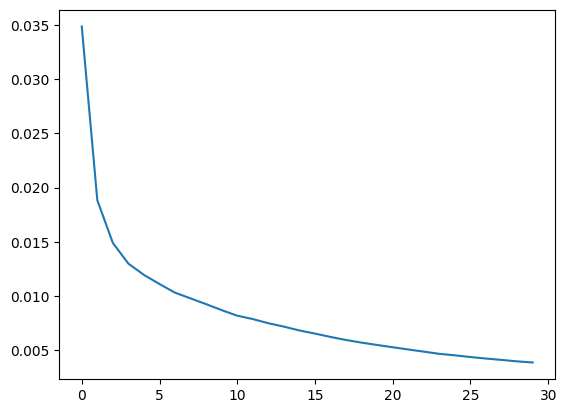

In [17]:
plt.plot(training_loss)

In [21]:
model_path = artifacts_path.joinpath('deeplab.pth')

In [21]:
torch.save(model.state_dict(), model_path)

In [22]:
get_file_size(model_path)

'82.85MiB'

In [22]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [29]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [30]:
evaluator = ClassificationEvaluator(NUM_CLASS + 1, DEVICE)

In [31]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 40/40 [00:22<00:00,  1.80it/s]

MulticlassJaccardIndex()


In [33]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.65 
bicycle        : 0.27 
bird           : 0.67 
boat           : 0.43 
bottle         : 0.55 
bus            : 0.56 
car            : 0.61 
cat            : 0.67 
chair          : 0.23 
cow            : 0.51 
diningtable    : 0.48 
dog            : 0.56 
horse          : 0.49 
motorbike      : 0.62 
person         : 0.67 
pottedplant    : 0.26 
sheep          : 0.66 
sofa           : 0.29 
train          : 0.63 
tvmonitor      : 0.5  
----------------------
total          : 0.52 


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

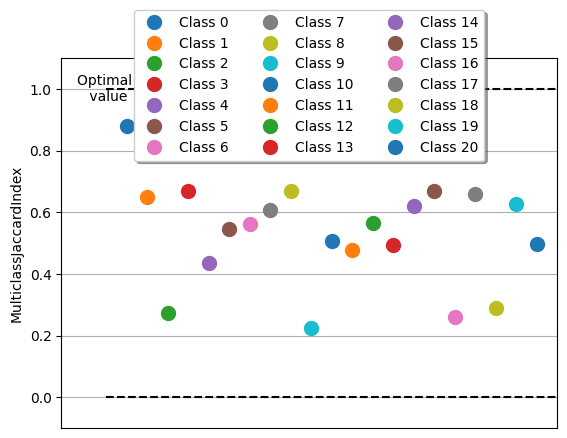

In [34]:
metric.plot()

### for image in dataset

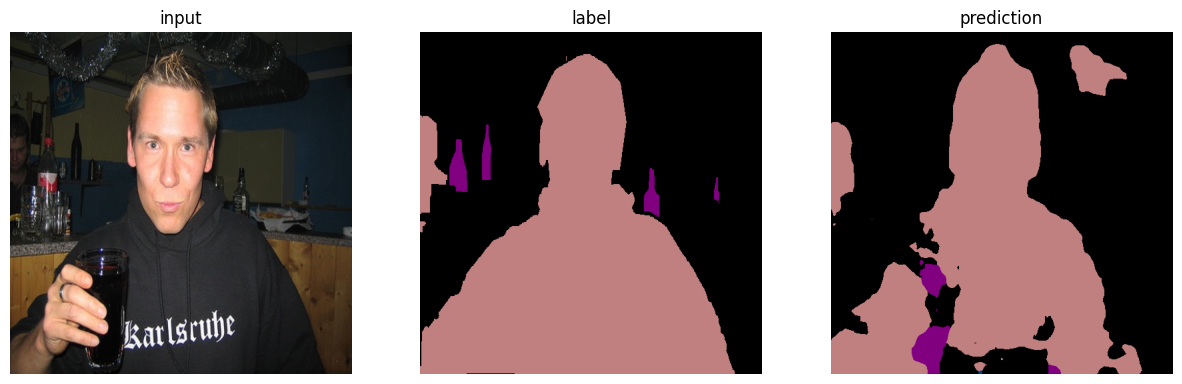

In [23]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

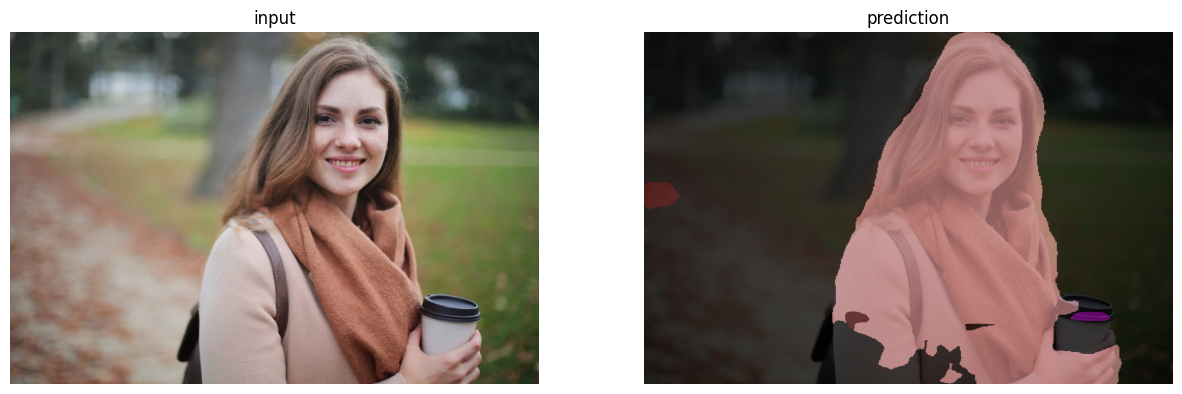

In [24]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )